## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [31]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "F:\PlaneLogs"

# Local path to trained weights file
MODEL_PATH = "F:\PlaneLogs\plane20231223T1118\mask_rcnn_plane_0300.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(MODEL_PATH):
    utils.download_trained_weights(MODEL_PATH)

## Configurations

In [32]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import plane
config = plane.PlaneConfig()
PLANE_DIR = "dataset"

In [33]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [34]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [35]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [36]:
# Build validation dataset
dataset = plane.PlaneDataset()
dataset.load_plane(PLANE_DIR,"test")
# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 14
Classes: ['BG', 'pesawat', 'ekor', 'pintu', 'sayap', 'mesin']


## Load Model

In [37]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
weights_path = MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  F:\PlaneLogs\plane20231223T1118\mask_rcnn_plane_0300.h5
Re-starting from epoch 300


## Run Detection

image ID: plane.0062765.jpg (0) dataset\test\0062765.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (7,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (7, 4)                min:   36.00000  max:  992.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  uint8


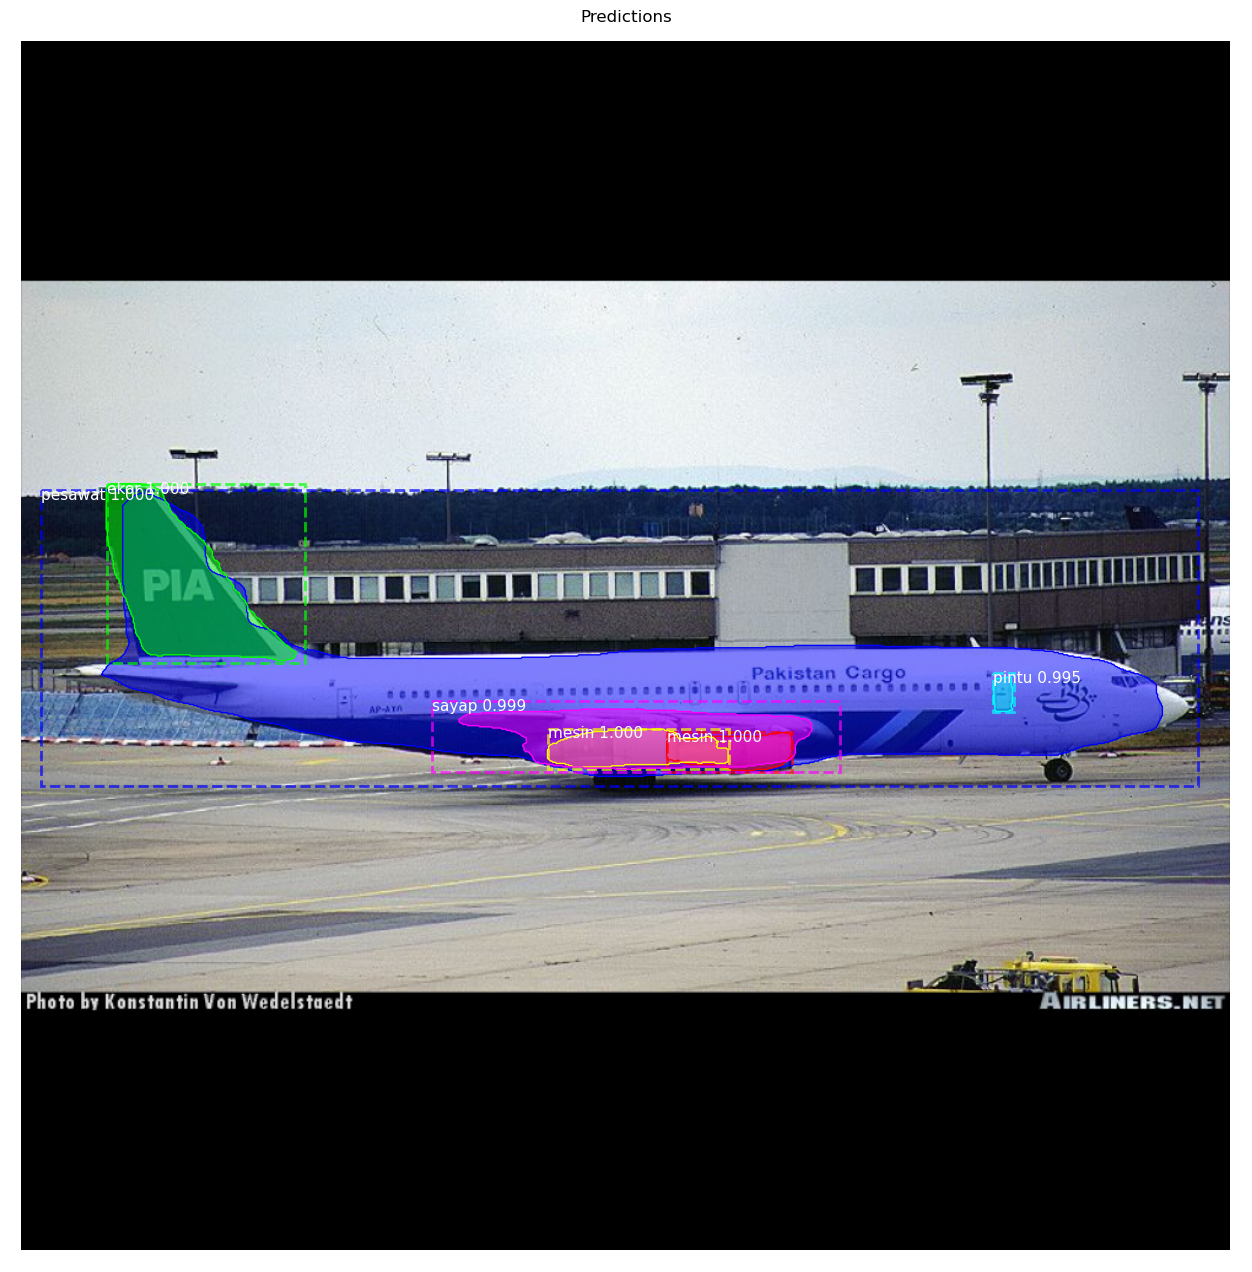

In [40]:
image_id = dataset.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

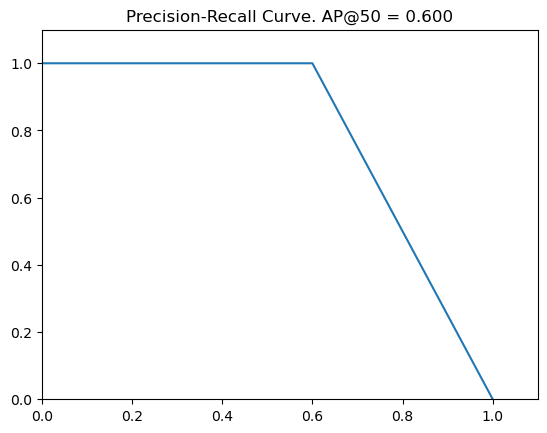

In [72]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

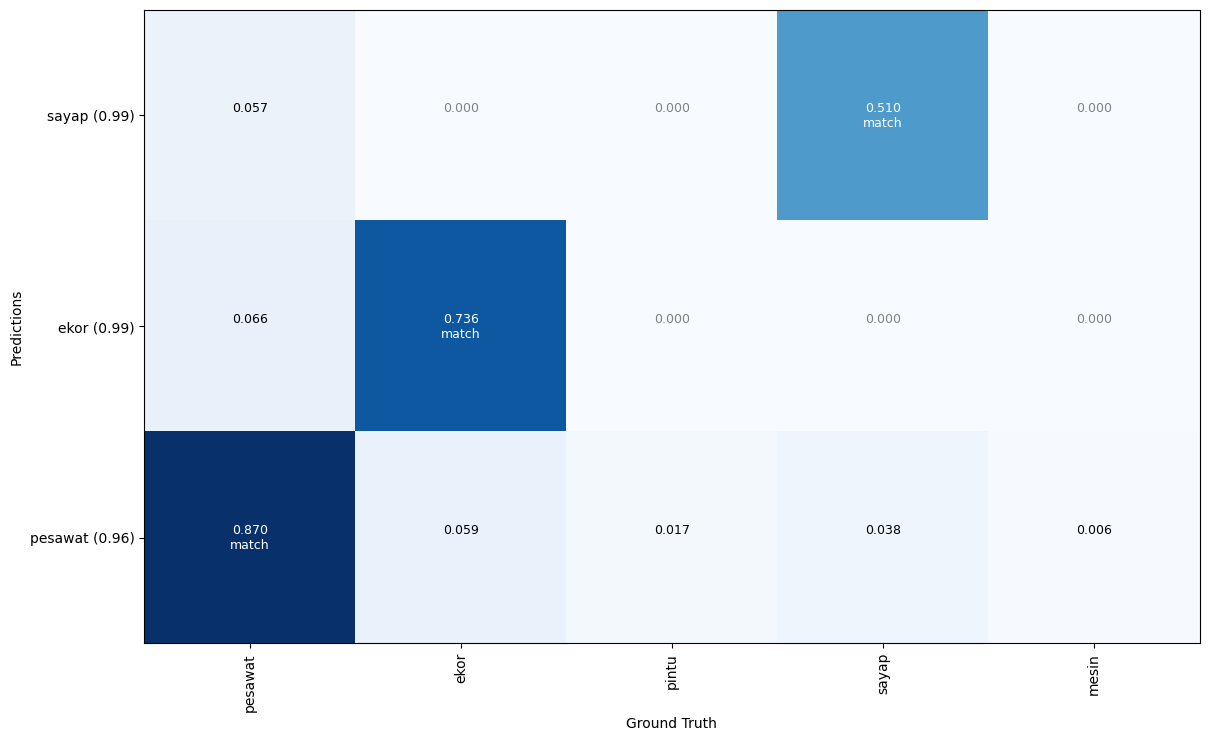

In [73]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [74]:
import imgaug
imgaug.__version__

'0.2.7'

### Compute mAP @ IoU=50 on Batch of Images

In [75]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        info = dataset.image_info[image_id]
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        print(f"{info['id']}\t:\t{AP}\t:\t{np.mean(precisions)}\t:\t{np.mean(recalls)}")
        APs.append(AP)
    return APs

# Pick a set of random images
APs = compute_batch_ap(dataset.image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

0048341.jpg	:	1.0	:	0.8571428571428571	:	0.5714285778147834
0062781.jpg	:	1.0	:	0.875	:	0.5625000018626451
0063113.jpg	:	0.7222222064932188	:	0.7708333333333334	:	0.4583333358168602
0063291.jpg	:	0.9666666686534882	:	0.8333333333333334	:	0.6000000070780516
0063435.jpg	:	1.0	:	0.8333333333333334	:	0.5833333333333334
0075758.jpg	:	0.9761904733521598	:	0.8571428571428572	:	0.5925925920406977
0113201.jpg	:	1.0	:	0.8571428571428571	:	0.5714285778147834
0147047.jpg	:	1.0	:	0.8285714285714285	:	0.6428571428571429
0198101.jpg	:	0.75	:	0.7642857142857142	:	0.5714285714285714
0250399.jpg	:	0.3333333432674408	:	0.6666666666666666	:	0.4444444477558136
0275123.jpg	:	1.0	:	0.8571428571428571	:	0.5714285778147834
0275719.jpg	:	1.0	:	0.8541666666666667	:	0.6250000055879354
0314131.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0321755.jpg	:	1.0	:	0.8571428571428571	:	0.5714285778147834
0345994.jpg	:	1.0	:	0.8571428571428571	:	0.5714285778147834
0356165.jpg	:	1.0	:	0.8541666666666667

In [ ]:
0048341.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0062781.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0063113.jpg	:	0.7222222064932188	:	0.7708333333333334	:	0.4583333358168602
0063291.jpg	:	0.9666666686534882	:	0.8333333333333334	:	0.6000000070780516
0063435.jpg	:	1.0	                :	0.8333333333333334	:	0.5833333333333334
0075758.jpg	:	0.9761904733521598	:	0.8571428571428572	:	0.5925925920406977
0113201.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0147047.jpg	:	1.0	                :	0.8285714285714285	:	0.6428571428571429
0198101.jpg	:	0.75	            :	0.7642857142857142	:	0.5714285714285714
0250399.jpg	:	0.3333333432674408	:	0.6666666666666666	:	0.4444444477558136
0275123.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0275719.jpg	:	1.0	                :	0.8541666666666667	:	0.6250000055879354
0314131.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0321755.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0345994.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0356165.jpg	:	1.0	                :	0.8541666666666667	:	0.6250000055879354
0458781.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0481847.jpg	:	1.0	                :	0.8333333333333334	:	0.5833333333333334
0482763.jpg	:	0.6000000238418579	:	0.8	                :	0.44000000655651095
0536511.jpg	:	0.1666666716337204	:	0.513888888888889	:	0.2777777810891469
0536721.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0582367.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0602177.jpg	:	1.0	                :	0.873015873015873	:	0.6111111127667956
0624128.jpg	:	0.8333333134651184	:	0.8571428571428571	:	0.5000000021287373
0638654.jpg	:	0.8333333134651184	:	0.8571428571428571	:	0.5000000021287373
0689276.jpg	:	1.0	                :	0.8541666666666667	:	0.6250000055879354
0699599.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0730793.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0732410.jpg	:	0.8571428656578064	:	0.875	            :	0.5000000093132257
0732667.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0740881.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0745103.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0760910.jpg	:	0.6666666865348816	:	0.8333333333333334	:	0.4444444502393405
0810608.jpg	:	0.9761904733521598	:	0.8571428571428572	:	0.5925925920406977
0869692.jpg	:	0.5500000193715096	:	0.7285714285714285	:	0.45714286608355387
0875317.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0879892.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0887066.jpg	:	0.800000011920929	:	0.8333333333333334	:	0.5000000074505806
0901498.jpg	:	0.8333333134651184	:	0.8571428571428571	:	0.5000000021287373
0901521.jpg	:	1.0	                :	0.8541666666666667	:	0.6250000055879354
0907364.jpg	:	1.0	                :	0.8333333333333334	:	0.5833333333333334
0907378.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0923884.jpg	:	0.8333333134651184	:	0.8571428571428571	:	0.5000000021287373
0939607.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
0987261.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
0994960.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
1009831.jpg	:	0.9666666686534882	:	0.8333333333333334	:	0.6000000070780516
1017179.jpg	:	0.7200000107288361	:	0.7583333333333333	:	0.5250000078231096
1036881.jpg	:	0.75	            :	0.7916666666666666	:	0.5416666666666666
1068565.jpg	:	0.75	            :	0.7916666666666666	:	0.5416666666666666
1148180.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
1152266.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
1188390.jpg	:	0.800000011920929	:	0.8285714285714285	:	0.5428571509463447
1193587.jpg	:	0.7600000143051148	:	0.7999999999999999	:	0.514285724077906
1199327.jpg	:	1.0	                :	0.875	            :	0.5625000018626451
1288661.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
1298905.jpg	:	1.0	                :	0.8285714285714285	:	0.6428571428571429
1318819.jpg	:	0.6333333492279053	:	0.7833333333333333	:	0.47916667349636555
1346004.jpg	:	1.0	                :	0.8386243386243386	:	0.6666666716337204
1426527.jpg	:	0.6875	            :	0.75	            :	0.5
1446378.jpg	:	1.0	                :	0.8333333333333334	:	0.5833333333333334
1514481.jpg	:	0.7499999999999999	:	0.6666666666666666	:	0.53125
1514484.jpg	:	0.5333333492279053	:	0.6833333333333333	:	0.41666667349636555
1518652.jpg	:	0.8333333134651184	:	0.8571428571428571	:	0.5000000021287373
1691787.jpg	:	0.10000000149011612	:	0.375	            :	0.30000000074505806
1862134.jpg	:	1.0	                :	0.8571428571428571	:	0.5714285778147834
mAP @ IoU=50:  0.8664027191612542

### Compute mAP per Parts

In [80]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids,class_id):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        gt_index = gt_class_id==class_id
        info = dataset.image_info[image_id]
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        res_index = r['class_ids']==class_id
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox[gt_index], gt_class_id[gt_index], gt_mask[:,:,gt_index],
                              r['rois'][res_index], r['class_ids'][res_index], 
                              r['scores'][res_index], r['masks'][:,:,res_index])
        print(f"{info['id']}\t:\t{AP}")
        APs.append(AP)
    return APs

APs = compute_batch_ap(dataset.image_ids,5)
print("mAP @ IoU=50: ", np.mean(APs))

0048341.jpg	:	1.0
0062781.jpg	:	1.0
0063113.jpg	:	1.0
0063291.jpg	:	1.0
0063435.jpg	:	1.0
0075758.jpg	:	1.0
0113201.jpg	:	1.0
0147047.jpg	:	1.0
0198101.jpg	:	1.0
0250399.jpg	:	0.0
0275123.jpg	:	1.0
0275719.jpg	:	1.0
0314131.jpg	:	0.0
0321755.jpg	:	1.0
0345994.jpg	:	1.0
0356165.jpg	:	1.0
0458781.jpg	:	1.0
0481847.jpg	:	0.0
0482763.jpg	:	0.0
0536511.jpg	:	0.0
0536721.jpg	:	1.0
0582367.jpg	:	1.0
0602177.jpg	:	1.0
0624128.jpg	:	1.0
0638654.jpg	:	1.0
0689276.jpg	:	1.0
0699599.jpg	:	1.0
0730793.jpg	:	1.0
0732410.jpg	:	0.5
0732667.jpg	:	1.0
0740881.jpg	:	1.0
0745103.jpg	:	1.0
0760910.jpg	:	0.0
0810608.jpg	:	1.0
0869692.jpg	:	0.0
0875317.jpg	:	1.0
0879892.jpg	:	1.0
0887066.jpg	:	1.0
0901498.jpg	:	0.5
0901521.jpg	:	1.0
0907364.jpg	:	1.0
0907378.jpg	:	1.0
0923884.jpg	:	1.0
0939607.jpg	:	1.0
0987261.jpg	:	1.0
0994960.jpg	:	1.0
1009831.jpg	:	1.0
1017179.jpg	:	0.0


d:\Programming Related\planes_mrcnn\Mask_RCNN_TF2\mrcnn\utils.py:735: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


1036881.jpg	:	nan
1068565.jpg	:	0.0
1148180.jpg	:	1.0
1152266.jpg	:	1.0
1188390.jpg	:	1.0
1193587.jpg	:	0.5
1199327.jpg	:	1.0
1288661.jpg	:	1.0
1298905.jpg	:	1.0
1318819.jpg	:	0.5
1346004.jpg	:	1.0
1426527.jpg	:	0.0
1446378.jpg	:	0.0


d:\Programming Related\planes_mrcnn\Mask_RCNN_TF2\mrcnn\utils.py:735: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


1514481.jpg	:	nan
1514484.jpg	:	0.5
1518652.jpg	:	1.0
1691787.jpg	:	0.0
1862134.jpg	:	1.0
mAP @ IoU=50:  nan


In [ ]:
0048341.jpg	:	1.0
0062781.jpg	:	1.0
0063113.jpg	:	1.0
0063291.jpg	:	1.0
0063435.jpg	:	1.0
0075758.jpg	:	1.0
0113201.jpg	:	1.0
0147047.jpg	:	1.0
0198101.jpg	:	1.0
0250399.jpg	:	0.0
0275123.jpg	:	1.0
0275719.jpg	:	1.0
0314131.jpg	:	0.0
0321755.jpg	:	1.0
0345994.jpg	:	1.0
0356165.jpg	:	1.0
0458781.jpg	:	1.0
0481847.jpg	:	0.0
0482763.jpg	:	0.0
0536511.jpg	:	0.0
0536721.jpg	:	1.0
0582367.jpg	:	1.0
0602177.jpg	:	1.0
0624128.jpg	:	1.0
0638654.jpg	:	1.0
0689276.jpg	:	1.0
0699599.jpg	:	1.0
0730793.jpg	:	1.0
0732410.jpg	:	0.5
0732667.jpg	:	1.0
0740881.jpg	:	1.0
0745103.jpg	:	1.0
0760910.jpg	:	0.0
0810608.jpg	:	1.0
0869692.jpg	:	0.0
0875317.jpg	:	1.0
0879892.jpg	:	1.0
0887066.jpg	:	1.0
0901498.jpg	:	0.5
0901521.jpg	:	1.0
0907364.jpg	:	1.0
0907378.jpg	:	1.0
0923884.jpg	:	1.0
0939607.jpg	:	1.0
0987261.jpg	:	1.0
0994960.jpg	:	1.0
1009831.jpg	:	1.0
1017179.jpg	:	0.0
1036881.jpg	:	0
1068565.jpg	:	0.0
1148180.jpg	:	1.0
1152266.jpg	:	1.0
1188390.jpg	:	1.0
1193587.jpg	:	0.5
1199327.jpg	:	1.0
1288661.jpg	:	1.0
1298905.jpg	:	1.0
1318819.jpg	:	0.5
1346004.jpg	:	1.0
1426527.jpg	:	0.0
1446378.jpg	:	0.0
1514481.jpg	:	0
1514484.jpg	:	0.5
1518652.jpg	:	1.0
1691787.jpg	:	0.0
1862134.jpg	:	1.0
mAP @ IoU=50:  nan

0062765.jpg
0064932.jpg
0116175.jpg
0328235.jpg
0447936.jpg
0457894.jpg
0717480.jpg
0907384.jpg
1514522.jpg
1707891.jpg
1713236.jpg
1833887.jpg
2021695.jpg
2127935.jpg


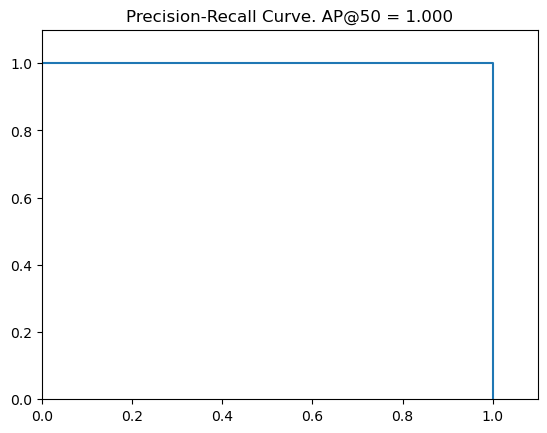

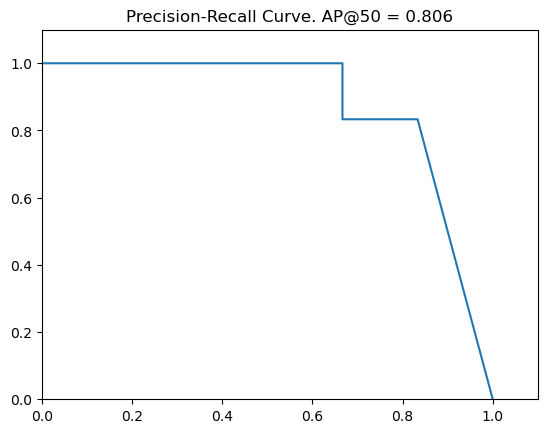

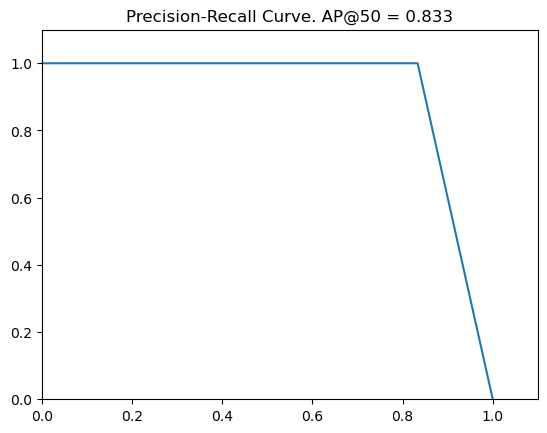

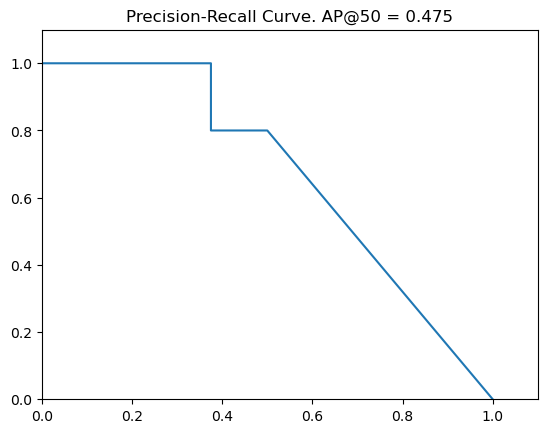

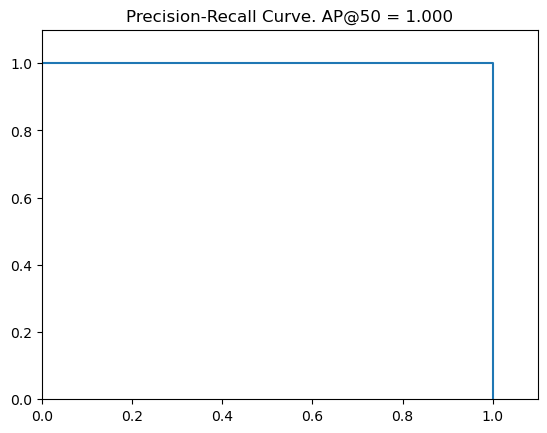

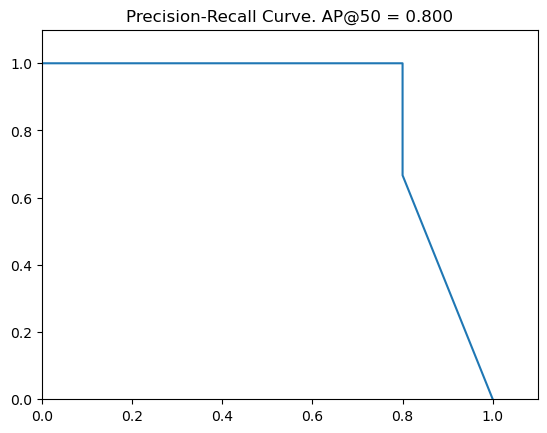

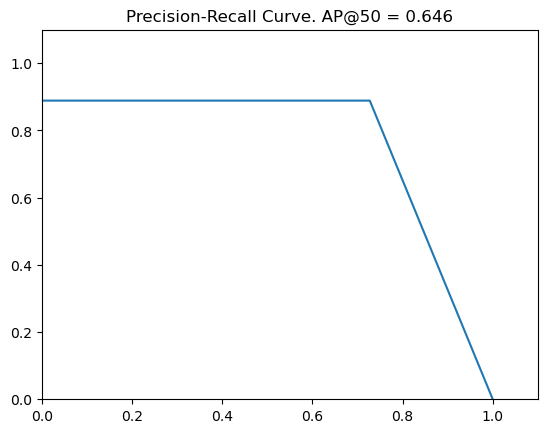

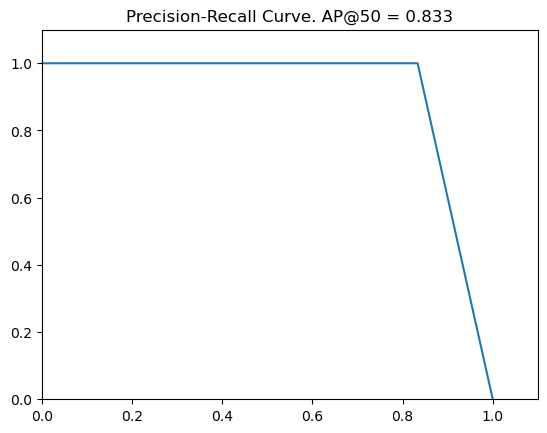

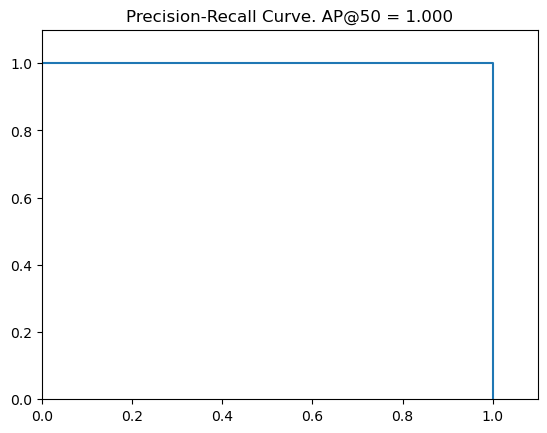

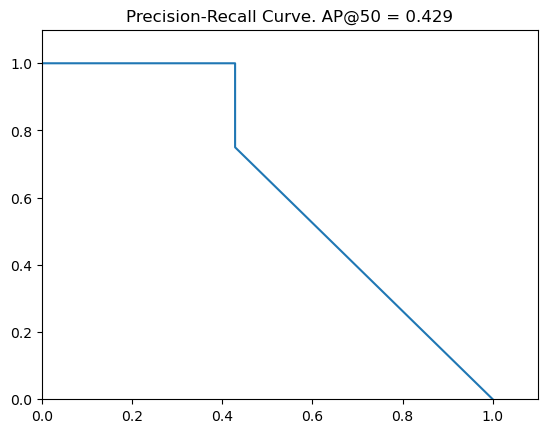

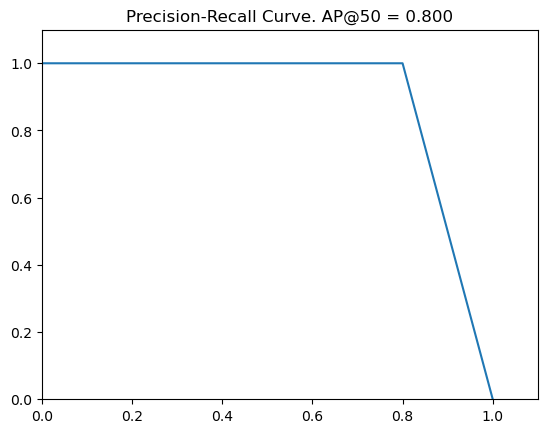

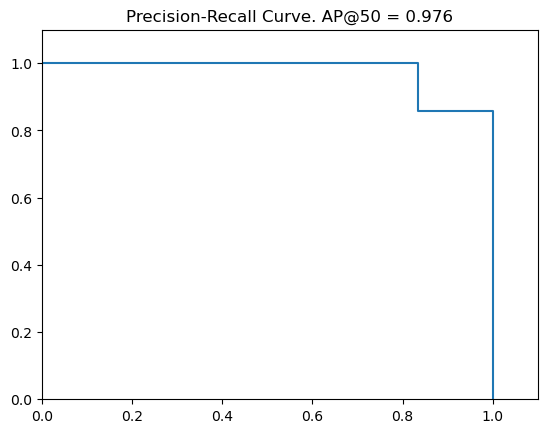

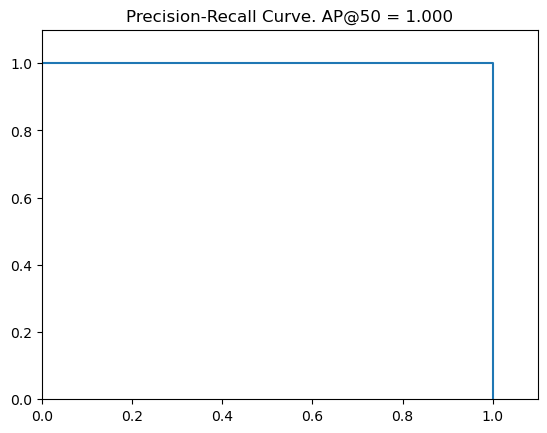

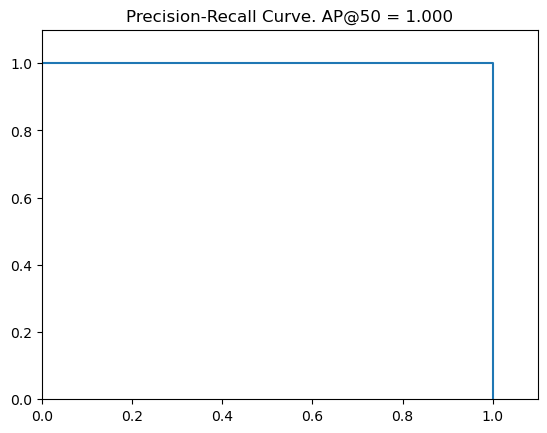

In [15]:
for image_id in dataset.image_ids:
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                                image_id)
    info = dataset.image_info[image_id]
    # Run object detection
    results = model.detect([image], verbose=0)
    # Compute AP
    r = results[0]
    print(f"{info['id']}")
    
    # Display results
    ax = get_ax(1)
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                        dataset.class_names, r['scores'], ax=ax,
                        title="Predictions")

    # Display PR Curve
    # AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
    #                                       r['rois'], r['class_ids'], r['scores'], r['masks'])
    # visualize.plot_precision_recall(AP, precisions, recalls)

In [18]:
np.mean(precisions)

0.875